In [1]:
import numpy as np
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from matplotlib.ticker import ScalarFormatter

In [2]:
palette = sns.color_palette("colorblind")
palette2 = sns.color_palette("tab10")[2:4]
palette3 = sns.color_palette("viridis", 10)
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

## Palmer, Huk, and Shadlen (2005) The effect of stimulus strength on the speed and accuracy of a perceptual decision

In [3]:
def make_palmer_dataframe():
    # convert original matlab files from Palmer et al 2005 into a single pandas dataframe
    names = ['JP', 'AH']
    dfs = []
    for i, filename in enumerate(['data/e12jp_bytrial.mat', 'data/e12ah_bytrial.mat']):
        f = scipy.io.loadmat(filename)
        emp = f['Data']
        df = pd.DataFrame({
                'type': 'human',
                'name': [names[i] for j in range(len(emp[:,0]))],
                'trial': emp[:,7-1],
                'coherence': emp[:,22-1]/10,
                'goodtrial': emp[:,20-1],
                'accuracy': emp[:,14-1]*100,
                'RT': emp[:,15-1]/1000,
                'condition': emp[:,26-1]
            })
        data = df.query("goodtrial==1")
        data.loc[data["condition"] == 1.0, "condition"] = "speed"
        data.loc[data["condition"] == 2.0, "condition"] = "normal"
        data.loc[data["condition"] == 3.0, "condition"] = "accuracy"
        dfs.append(data)
    palmer = pd.concat(dfs, ignore_index=True)
    palmer = palmer.drop(columns=['goodtrial'])
    palmer.to_pickle("data/palmer2005.pkl")
    return palmer
palmer = make_palmer_dataframe()
print(palmer)

       type name  trial  coherence  accuracy     RT condition
0     human   JP    2.0       12.8     100.0  0.558     speed
1     human   JP    3.0        0.8     100.0  0.366     speed
2     human   JP    4.0       25.6     100.0  0.398     speed
3     human   JP    5.0        0.8     100.0  0.486     speed
4     human   JP    6.0        1.6       0.0  0.438     speed
...     ...  ...    ...        ...       ...    ...       ...
4920  human   AH  164.0        3.2     100.0  0.426  accuracy
4921  human   AH  165.0        6.4     100.0  1.742  accuracy
4922  human   AH  166.0       12.8     100.0  0.622  accuracy
4923  human   AH  167.0        3.2     100.0  1.490  accuracy
4924  human   AH  168.0        0.8       0.0  3.694  accuracy

[4925 rows x 7 columns]


C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_6232\1991692391.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'speed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data["condition"] == 1.0, "condition"] = "speed"


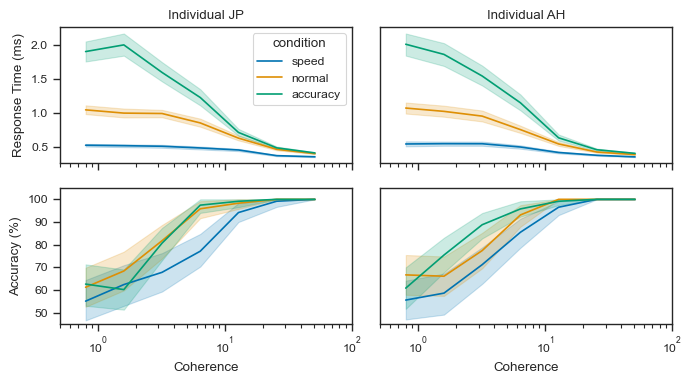

In [4]:
def plot_palmer():
    palmer = pd.read_pickle('data/palmer2005.pkl')
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=palmer.query("name=='JP'"), x='coherence', y='RT', hue='condition', palette=palette[:3], ax=axes[0][0])
    sns.lineplot(data=palmer.query("name=='AH'"), x='coherence', y='RT', hue='condition', palette=palette[:3], ax=axes[0][1])
    sns.lineplot(data=palmer.query("name=='JP'"), x='coherence', y='accuracy', hue='condition', palette=palette[:3], ax=axes[1][0])
    sns.lineplot(data=palmer.query("name=='AH'"), x='coherence', y='accuracy', hue='condition', palette=palette[:3], ax=axes[1][1])
    axes[0][0].set_xscale('log')
    axes[0][0].set(ylabel="Response Time (ms)", title="Individual JP")
    axes[0][1].set(ylabel=None, yticks=(()), title="Individual AH")
    axes[1][0].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1][1].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=(()))
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/palmer2005.svg")
    fig.savefig(f"plots/palmer2005.png", dpi=600)
plot_palmer()

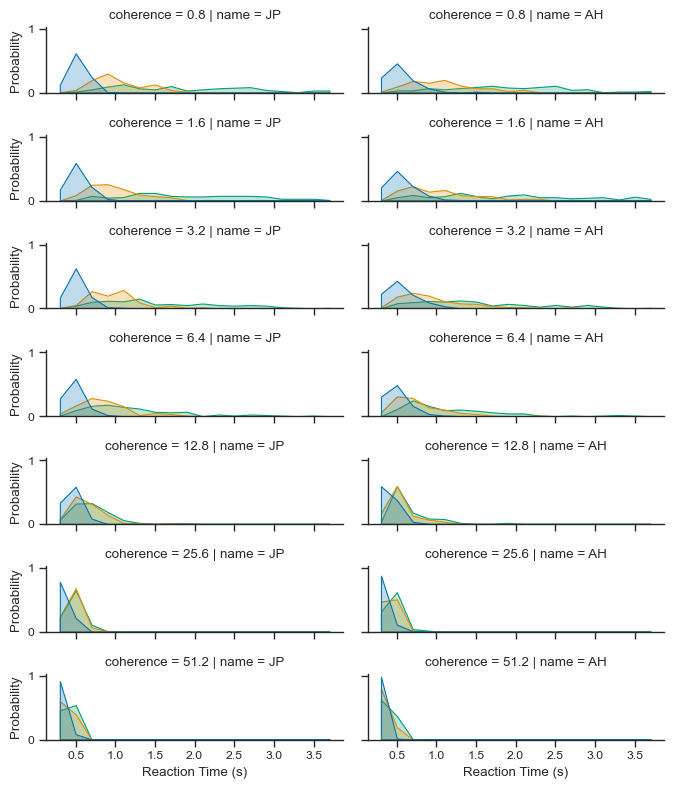

In [5]:
def plot_palmer2():
    palmer = pd.read_pickle('data/palmer2005.pkl')
    coherences = np.sort(palmer['coherence'].unique())
    fig = sns.FacetGrid(palmer, col="name",  row="coherence", height=1.15, aspect=3)
    fig.map_dataframe(sns.histplot, x="RT", stat='probability', bins=np.arange(0.2, 4, 0.2), element="poly", hue="condition", common_norm=False, palette=palette[:3])
    fig.set_xlabels("Reaction Time (s)")
    fig.savefig(f"plots/palmer2005_distributions.svg")
    fig.savefig(f"plots/palmer2005_distributions.png", dpi=600)
plot_palmer2()

In [4]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    # print(a, b, distance)
    return distance

In [5]:
def get_loss(data, coherences, condition):
    total_loss = 0
    for coherence in coherences:
        if condition=="speed":
            bins = np.arange(0.0, 1.0, 0.1)
        if condition=="normal":
            bins = np.arange(0.0, 2.0, 0.2)
        if condition=="accuracy":
            bins = np.arange(0.0, 4.0, 0.4)
        rts_sim = data.query("type=='model' & coherence==@coherence & condition==@condition")['RT'].to_numpy()
        rts_emp = data.query("type=='human' & coherence==@coherence & condition==@condition")['RT'].to_numpy()
        hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
        hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
        normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
        normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
        loss = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
        print(f"coherence {coherence}, loss {loss}")
        total_loss += loss
    return total_loss

In [195]:
filename, condition = "speed11", "speed"
palmer = pd.read_pickle('data/palmer2005.pkl').query("name=='JP'")
sim = pd.read_pickle(f'data/{filename}.pkl')
data = pd.concat([palmer, sim])
coherences = np.sort(data['coherence'].unique())
get_loss(data, coherences, condition)

coherence 0.8, loss nan
coherence 1.6, loss nan
coherence 3.2, loss nan
coherence 6.4, loss nan
coherence 12.8, loss nan
coherence 25.6, loss nan
coherence 51.2, loss 0.23511572397868394


C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_4736\3821755503.py:14: RuntimeWarning: divide by zero encountered in divide
  normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_4736\3821755503.py:14: RuntimeWarning: invalid value encountered in divide
  normed_hist_rts_sim = hist_rts_sim / len(rts_sim)


nan

In [6]:
def compare_palmer_model(filename, sharex=False):
    palmer = pd.read_pickle('data/palmer2005.pkl').query("name=='JP'")
    sim = pd.read_pickle(f'data/{filename}.pkl')
    data = pd.concat([palmer, sim])
    coherences = np.sort(data['coherence'].unique())

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=((7.08, 4)))
    for c, condition in enumerate(['speed', 'normal', 'accuracy']):
        sns.lineplot(data=data.query("condition==@condition"), x='coherence', y='RT', style='type', color=palette[c], markers=True, ax=axes[0][c])
        sns.lineplot(data=data.query("condition==@condition"), x='coherence', y='accuracy', style="type", color=palette[c], markers=True, ax=axes[1][c])
    axes[0][0].set(title="speed", ylabel="Response Time (ms)")
    axes[0][1].set(title="normal", ylabel=None)
    axes[0][2].set(title="accuracy", ylabel=None)
    axes[1][0].set_xscale('log')
    axes[1][0].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1][1].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=[])
    axes[1][2].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=[])
    axes[0][1].get_legend().remove()
    axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_palmer_model.svg")
    fig.savefig(f"plots/compare_palmer_model.png", dpi=600)

    fig = sns.FacetGrid(data, col="condition", row="coherence", hue="type", palette=palette[:2], height=1.5, aspect=2, sharex=sharex)
    i=0
    for ax in fig.axes_dict.items():
        coherence = ax[0][0]
        condition = ax[0][1]
        if condition=="speed":
            bins = np.arange(0.0, 1.0, 0.1)
        if condition=="normal":
            bins = np.arange(0.0, 2.0, 0.2)
        if condition=="accuracy":
            bins = np.arange(0.0, 4.0, 0.4)
        sns.histplot(data=data.query("condition==@condition & coherence==@coherence"), x='RT', hue='type',
                     bins=bins, stat='percent', element="poly", common_norm=False, palette=palette[:2], ax=ax[1])
        if i>0: ax[1].get_legend().remove()
        i+=1
    # fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=8)
    fig.set_xlabels("Reaction Time (s)")
    fig.savefig(f"plots/compare_palmer_model_RTs.svg")
    fig.savefig(f"plots/compare_palmer_model_RTs.png", dpi=600)

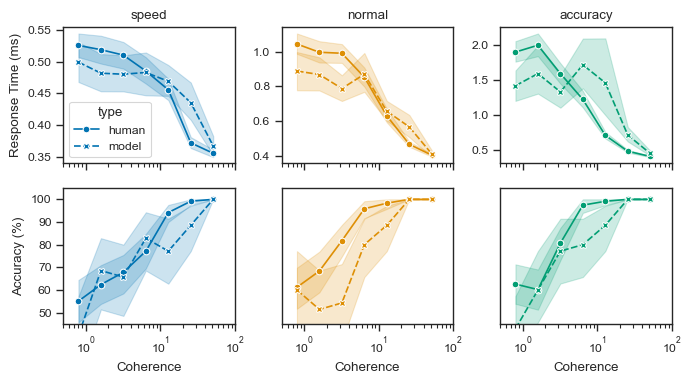

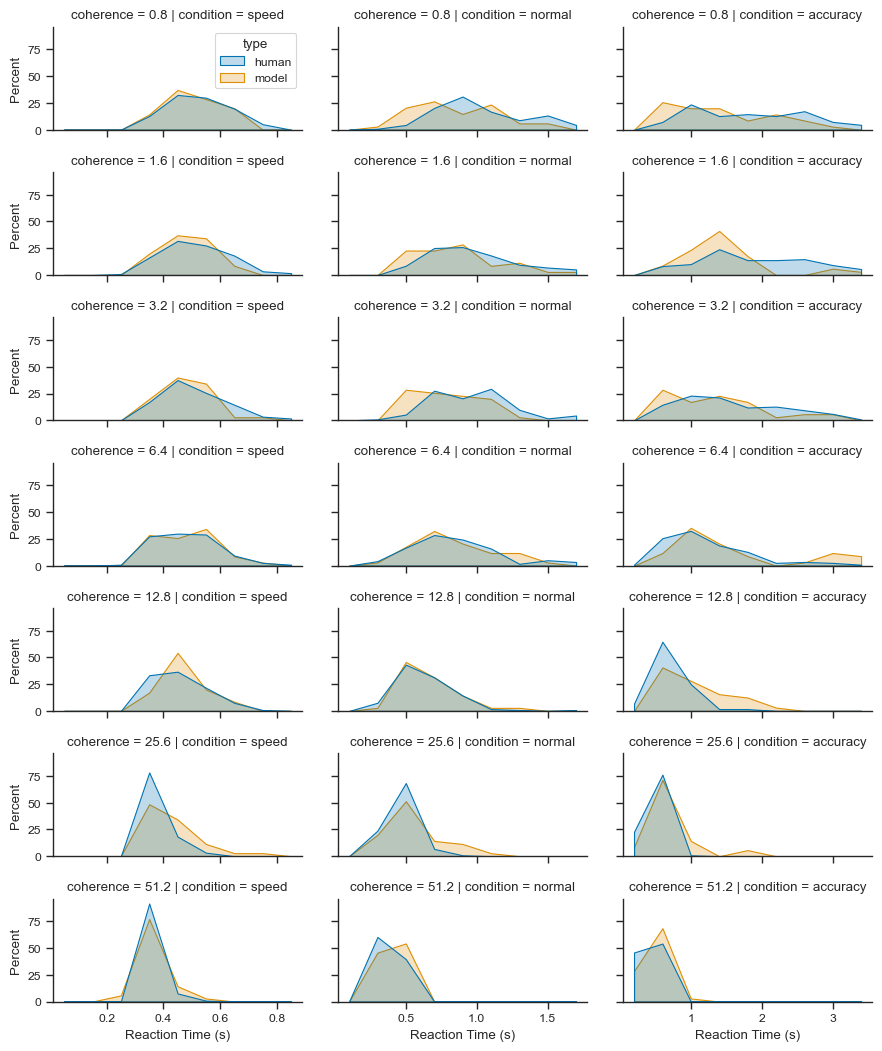

In [8]:
sim1 = pd.read_pickle(f'data/speednov16chirel.pkl')
sim2 = pd.read_pickle(f'data/normalnov16chirel.pkl')
sim3 = pd.read_pickle(f'data/accuracynov16chirel.pkl')
sim = pd.concat([sim1, sim2, sim3], ignore_index=True)
sim.to_pickle("data/nov16full.pkl")
compare_palmer_model("nov16full", sharex='col')

## Churchland, Kiani, and Shadlen (2008) Decision-making with multiple alternatives

In [53]:
def make_churchland_firing_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('nActions', 'coherence', 'trial', 'neuron', 'RT', 'accuracy', 'time', 'firing rate')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times
    pref = 1  # preferred direction 

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            nCoherences = len(emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'])
            for c in range(nCoherences):
                # select preferred direction (pref) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                dat = emp[neuron]['allnums'][nActions-1]['data'][pref]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    if type(dat[trial]['rt'])!=float: continue
                    RT = int(dat[trial]['rt'])
                    coherence = float(dat[trial]['coh']) / 10
                    spike_times = dat[trial]['dots']
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(spike_times)!=np.ndarray or len(spike_times)==0:  continue  # skip empty data
                    spike_times = np.array(dat[trial]['dots']).astype(int)  # remove sub-ms precision in spike times
                    tstart = spike_times[0]
                    tend = spike_times[-1]+1
                    times = np.arange(tstart, tend)  # time relative to stimulus onset
                    spike_array = np.zeros_like(times)
                    spike_array[spike_times-tstart] = 1  # put a value of 1 at the index of every spike time
                    firing_rates = filter.filt(1000*spike_array)  # compute firing rate in spikes/second (Hz) by filtering with lowpass filter
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=100/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    df = pd.DataFrame()
                    df['nActions'] = nActions*np.ones_like(times)
                    df['coherence'] = coherence*np.ones_like(times)
                    df['trial'] = trial*np.ones_like(times)
                    df['neuron'] = neuron*np.ones_like(times)
                    df['RT'] = RT*np.ones_like(times)
                    df['accuracy'] = accuracy*np.ones_like(times)
                    df['nActions'] = nActions*np.ones_like(times)
                    df['time'] = times
                    df['firing rate'] = firing_rates
                    dfs.append(df)

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_firing.pkl")
    return churchland

churchland_firing = make_churchland_firing_dataframe()

neuron 0, nActions 2, coherence 0.0, trial 0
neuron 0, nActions 2, coherence 0.0, trial 1
neuron 0, nActions 2, coherence 0.0, trial 2
neuron 0, nActions 2, coherence 0.0, trial 3
neuron 0, nActions 2, coherence 0.0, trial 4
neuron 0, nActions 2, coherence 0.0, trial 5
neuron 0, nActions 2, coherence 0.0, trial 6
neuron 0, nActions 2, coherence 0.0, trial 7
neuron 0, nActions 2, coherence 0.0, trial 8
neuron 0, nActions 2, coherence 0.0, trial 9
neuron 0, nActions 2, coherence 0.0, trial 10
neuron 0, nActions 2, coherence 0.0, trial 11
neuron 0, nActions 2, coherence 0.0, trial 12
neuron 0, nActions 2, coherence 0.0, trial 13
neuron 0, nActions 2, coherence 0.0, trial 14
neuron 0, nActions 2, coherence 0.0, trial 15
neuron 0, nActions 2, coherence 0.0, trial 16
neuron 0, nActions 2, coherence 0.0, trial 17
neuron 0, nActions 2, coherence 0.0, trial 18
neuron 0, nActions 2, coherence 0.0, trial 19
neuron 0, nActions 2, coherence 0.0, trial 20
neuron 0, nActions 2, coherence 0.0, trial 2

In [15]:
def make_churchland_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    # WARNING! This will produce a 2GB pickle file
    coherences = [0.0, 0.032, 0.064, 0.128, 0.256, 0.514, 0.768]
    dfs = []
    columns = ('nActions', 'coherence', 'RT', 'accuracy')
    emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']
    filter = Lowpass(tau=0.03)  # 30ms filter applied to spike times

    for neuron in range(len(emp)):
        for nActions in [2, 4]:
            if len(emp[neuron]['allnums'][nActions-1]['data'])==0: continue  # empty data
            for c, coherence in enumerate(coherences):
                # select preferred direction (0) and coherence (c)
                # note that we select stimulus-aligned data ('dotfire_time'), but both alignments are actually available within this data
                if c >= len(emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time']): continue  # empty data
                dat = emp[neuron]['allnums'][nActions-1]['data'][0]['dotfire_time'][c]['spiketimes']
                for trial in range(len(dat)):
                    print(f"neuron {neuron}, nActions {nActions}, coherence {coherence}, trial {trial}")
                    if type(dat[trial]['rt']) != float: continue  # empty data, skip
                    RT = int(dat[trial]['rt'])
                    accuracy = 100 if dat[trial]['score']==1 else 0
                    if coherence==0: accuracy=1/nActions  # accuracy is meaningless when coherence=0, since there is no right answer
                    dfs.append(pd.DataFrame([[nActions, 100*coherence, RT, accuracy]], columns=columns))

    churchland = pd.concat(dfs, ignore_index=True)
    churchland.to_pickle("data/churchland2008_behavior.pkl")
    return churchland

churchland_behavior = make_churchland_behavior_dataframe()

neuron 0, nActions 2, coherence 0.0, trial 0
neuron 0, nActions 2, coherence 0.0, trial 1
neuron 0, nActions 2, coherence 0.0, trial 2
neuron 0, nActions 2, coherence 0.0, trial 3
neuron 0, nActions 2, coherence 0.0, trial 4
neuron 0, nActions 2, coherence 0.0, trial 5
neuron 0, nActions 2, coherence 0.0, trial 6
neuron 0, nActions 2, coherence 0.0, trial 7
neuron 0, nActions 2, coherence 0.0, trial 8
neuron 0, nActions 2, coherence 0.0, trial 9
neuron 0, nActions 2, coherence 0.0, trial 10
neuron 0, nActions 2, coherence 0.0, trial 11
neuron 0, nActions 2, coherence 0.0, trial 12
neuron 0, nActions 2, coherence 0.0, trial 13
neuron 0, nActions 2, coherence 0.0, trial 14
neuron 0, nActions 2, coherence 0.0, trial 15
neuron 0, nActions 2, coherence 0.0, trial 16
neuron 0, nActions 2, coherence 0.0, trial 17
neuron 0, nActions 2, coherence 0.0, trial 18
neuron 0, nActions 2, coherence 0.0, trial 19
neuron 0, nActions 2, coherence 0.0, trial 20
neuron 0, nActions 2, coherence 0.0, trial 2

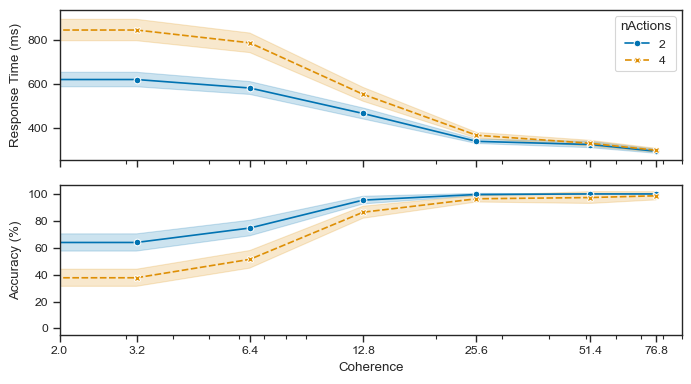

In [28]:
def plot_churchland_behavior():
    churchland_behavior =  pd.read_pickle("data/churchland2008_behavior.pkl")
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=churchland_behavior, x='coherence', y='RT', hue="nActions", style="nActions", palette=palette[:2], errorbar=('se', 5), markers=True, ax=axes[0])
    sns.lineplot(data=churchland_behavior, x='coherence', y='accuracy', hue="nActions", style="nActions", palette=palette[:2], errorbar=('se', 5), markers=True, ax=axes[1])
    # axes[1].set_xscale('log')
    # axes[1].set_xticks([20, 200, 500])
    axes[0].set(ylabel='Response Time (ms)')
    # axes[1].set(xscale='log', xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].set(xscale='log', xticks=[2, 3.2, 6.4, 12.8, 25.6, 51.4, 76.8], xlabel='Coherence', ylabel='Accuracy (%)')
    axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland2008_behavior.svg")
    fig.savefig(f"plots/churchland2008_behavior.png", dpi=600)
plot_churchland_behavior()

In [9]:
def plot_churchland_firing(coherences, tmin=0, tmax=400, name="default"):
    churchland = pd.read_pickle("data/churchland2008_firing.pkl")
    subdata = churchland.query("nActions==2 & time>@tmin & time<@tmax & coherence in @coherences & accuracy==100")
    subdata2 = churchland.query("nActions==4 & time>@tmin & time<@tmax & coherence in @coherences & accuracy==100")
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=subdata, x='time', y='firing rate', hue="coherence", palette=palette[:len(coherences)], ax=axes[0])
    sns.lineplot(data=subdata2, x='time', y='firing rate', hue="coherence", palette=palette[:len(coherences)], ax=axes[1])
    axes[0].set(ylabel="Firing Rate (Hz)", title='nActions 2')
    axes[1].set(xlabel="Time (ms)", ylabel="Firing Rate (Hz)", title='nActions 4')
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/churchland_firing_{name}.svg")
    fig.savefig(f"plots/churchland_firing_{name}.png", dpi=600)

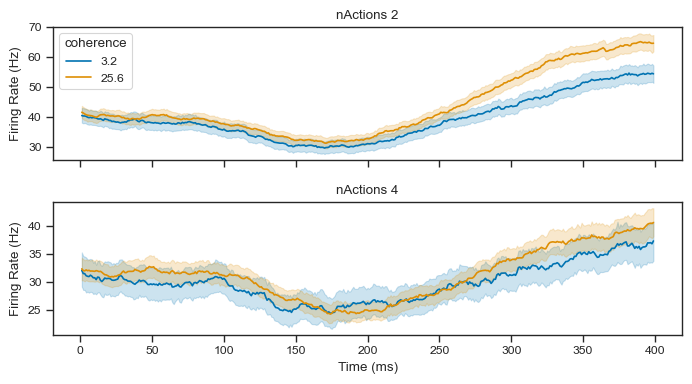

In [10]:
plot_churchland_firing(coherences=[3.2, 25.6], name='two')

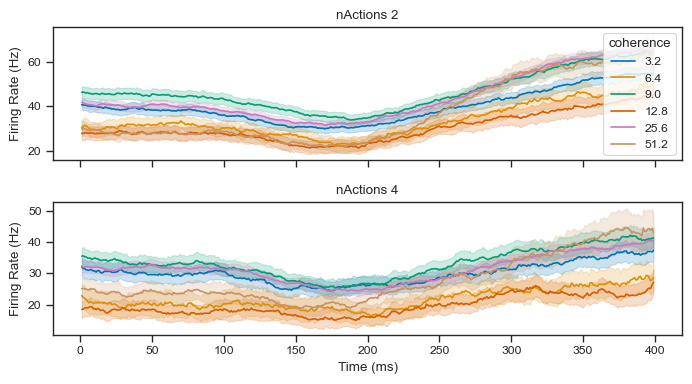

In [11]:
plot_churchland_firing(coherences=[3.2, 6.4, 9.0, 12.8, 25.6, 51.2], name='all')

## Parse Data Structure

In [3]:
emp = scipy.io.loadmat("data/both_monkeys_lip_nocon.mat", simplify_cells=True)['both_monkeys_lip_nocon']

In [4]:
# data from neuron 0
emp[0].keys()

dict_keys(['date', 'dots2', 'dots4', 'memory', 'overlap', 'depth', 'dots8', 'prefdir', 'whichunit', 'complete', 'prefire', 'iscomplete', 'location', 'angcont', 'dots8_partial', 'prefire_time', 'dotfire', 'sacfire', 'sacfireNULL', 'dotfireNULL', 'sacfirert', 'dotfirert', 'sacfireRT_NULL', 'dotfireRT_NULL', 'dotfirertNULL', 'sacfirertNULL', 'anglecontrol', 'otherdirs', 'allnums', 'newit', 'rts', 'anglecontrol45', 'monkey', 'plx_new'])

In [5]:
# data from 2-choice vs 4-choice task
emp[0]['allnums'][1]
emp[0]['allnums'][3]

{'data': [{'prefire': array([[  0.        ,   8.87197279],
          [ 32.        ,   9.14184154],
          [ 64.        ,   8.63611049],
          [128.        ,   9.16164961],
          [256.        ,  11.29464076],
          [512.        ,  11.36409673],
          [768.        ,   8.76712153]]),
   'prefire_time': [{'data': array([[-181.        ,    6.20915033],
            [-141.        ,    6.53594771],
            [-101.        ,    8.16993464],
            [ -61.        ,    8.66013072],
            [ -21.        ,    7.02614379],
            [  19.        ,    9.1503268 ],
            [  59.        ,   11.60130719],
            [  99.        ,   11.4379085 ],
            [ 139.        ,   10.62091503],
            [ 179.        ,    5.06535948],
            [ 219.        ,    5.06535948],
            [ 259.        ,    7.67973856],
            [ 299.        ,   10.51939513],
            [ 339.        ,    9.93320774],
            [ 379.        ,    8.28082808],
            [ 4

In [6]:
# preferred vs nonpreferred direction
emp[0]['allnums'][1]['data'][0]
emp[0]['allnums'][1]['data'][1]

{'prefire': array([[  0.        ,  11.2921899 ],
        [ 32.        ,  10.44219398],
        [ 64.        ,   8.9789009 ],
        [128.        ,  10.11321827],
        [256.        ,  10.67974684],
        [512.        ,  10.26143961],
        [768.        ,  11.90069874]]),
 'prefire_time': [{'data': array([[-181.        ,    9.09090909],
          [-141.        ,    9.09090909],
          [-101.        ,   10.38961039],
          [ -61.        ,   10.71428571],
          [ -21.        ,   10.38961039],
          [  19.        ,    8.76623377],
          [  59.        ,   13.96103896],
          [  99.        ,   15.90909091],
          [ 139.        ,   20.12987013],
          [ 179.        ,   13.31168831],
          [ 219.        ,    7.14285714],
          [ 259.        ,   10.71428571],
          [ 299.        ,   10.40312094],
          [ 339.        ,   15.50910317],
          [ 379.        ,   11.82608696],
          [ 419.        ,   10.3166133 ],
          [ 459.        ,

In [7]:
# spike times aligned with stimulus onset vs saccade event
emp[0]['allnums'][1]['data'][0]['dotfire_time']
emp[0]['allnums'][1]['data'][0]['sacfire_time']

[{'data': array([[-760.        ,   16.94915254],
         [-720.        ,   17.92114695],
         [-680.        ,   18.42105263],
         [-640.        ,   17.47572816],
         [-600.        ,   18.72659176],
         [-560.        ,   21.39037433],
         [-520.        ,   17.90763431],
         [-480.        ,   19.37984496],
         [-440.        ,   21.31782946],
         [-400.        ,   20.82248829],
         [-360.        ,   23.0700976 ],
         [-320.        ,   18.03530315],
         [-280.        ,   17.30486009],
         [-240.        ,   15.35240754],
         [-200.        ,   20.483546  ],
         [-160.        ,   17.76315789],
         [-120.        ,   16.77631579],
         [ -80.        ,   19.54397394],
         [ -40.        ,   24.02597403],
         [   0.        ,   16.88311688],
         [  40.        ,   13.31168831],
         [  80.        ,   16.23376623],
         [ 120.        ,   22.72727273],
         [ 160.        ,   11.68831169],
        

In [8]:
# which of the seven coherence values
emp[0]['allnums'][1]['data'][0]['dotfire_time'][0]
emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]

{'data': array([[-480.        ,   10.82251082],
        [-440.        ,   11.48648649],
        [-400.        ,   13.27140013],
        [-360.        ,   14.38848921],
        [-320.        ,   11.25      ],
        [-280.        ,    7.5       ],
        [-240.        ,    9.375     ],
        [-200.        ,   13.125     ],
        [-160.        ,   11.25      ],
        [-120.        ,    6.25      ],
        [ -80.        ,    9.375     ],
        [ -40.        ,   10.        ],
        [   0.        ,   11.25      ],
        [  40.        ,   10.6557377 ],
        [  80.        ,   13.75      ],
        [ 120.        ,   16.25      ],
        [ 160.        ,   20.        ],
        [ 200.        ,   21.25      ],
        [ 240.        ,   24.20051858]]),
 'coh': 768,
 'pspike': array([[-480,   15, 1386],
        [-440,   17, 1480],
        [-400,   20, 1507],
        [-360,   22, 1529],
        [-320,   18, 1600],
        [-280,   12, 1600],
        [-240,   15, 1600],
        [-2

In [9]:
# trial number
emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]  # trial number 0
emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][38]  # trial number 38

{'targtodots': 498.125,
 'targ': array([-310.05 ,  112.975,  195.075,  249.6  ]),
 'rt': 291.54999999981374,
 'dots': array([-808.175, -385.15 , -303.05 , -248.525,   97.475,  115.45 ,
         139.65 ,  157.   ,  169.375,  186.475,  227.675,  257.35 ,
         267.775,  287.85 ,  308.   ,  330.25 ,  348.4  ,  370.95 ]),
 'sacc': array([-1099.725,  -676.7  ,  -594.6  ,  -540.075,  -194.075,  -176.1  ,
         -151.9  ,  -134.55 ,  -122.175,  -105.075,   -63.875,   -34.2  ,
          -23.775,    -3.7  ,    16.45 ,    38.7  ,    56.85 ,    79.4  ]),
 'coh': 768,
 'dir': 135,
 'numtargs': 2,
 'choice': 135,
 'score': 1}

In [214]:
# access data
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['numtargs'])  # number of possible choices
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['coh'])  # coherence
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['rt'])  # RT
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['dots'])  # stimulus-aligned spike times
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['sacc'])  # saccade-aligned spike times
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['choice'])  # direction of monkey saccade
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][0]['score'])  # correct vs not (except for coh=0)

2
768
296.0500000000029
[-1275.075 -1063.125  -621.1    -362.125   -45.825   -12.225    22.675
   114.15    250.15    292.3     299.925   365.025   373.525   409.85
   416.125]
[-1571.125 -1359.175  -917.15   -658.175  -341.875  -308.275  -273.375
  -181.9     -45.9      -3.75      3.875    68.975    77.475   113.8
   120.075]
135
135
1


In [50]:
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][0]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][2]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][3]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][5]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][6]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][7]['dir'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][9]['dir'])  # direction of dot motion

135
135
135
135
135
135
135


In [46]:
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][0]['spiketimes'][0]['choice'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][1]['spiketimes'][2]['choice'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][2]['spiketimes'][3]['choice'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][3]['spiketimes'][5]['choice'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][4]['spiketimes'][6]['choice'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][5]['spiketimes'][7]['choice'])  # direction of dot motion
print(emp[0]['allnums'][1]['data'][0]['dotfire_time'][6]['spiketimes'][9]['choice'])  # direction of dot motion

135
135
135
135
135
135
135


In [45]:
print(emp[0]['allnums'][3]['data'][0]['dotfire_time'][0]['spiketimes'][0]['dir'])  # direction of dot motion
print(emp[0]['allnums'][3]['data'][1]['dotfire_time'][1]['spiketimes'][2]['dir'])  # direction of dot motion
print(emp[0]['allnums'][3]['data'][2]['dotfire_time'][2]['spiketimes'][3]['dir'])  # direction of dot motion
print(emp[0]['allnums'][3]['data'][3]['dotfire_time'][3]['spiketimes'][5]['dir'])  # direction of dot motion
print(emp[0]['allnums'][3]['data'][4]['dotfire_time'][4]['spiketimes'][6]['dir'])  # direction of dot motion
print(emp[0]['allnums'][3]['data'][0]['dotfire_time'][5]['spiketimes'][7]['dir'])  # direction of dot motion
print(emp[0]['allnums'][3]['data'][0]['dotfire_time'][6]['spiketimes'][9]['dir'])  # direction of dot motion


45
135
225
315


IndexError: list index out of range